# Swimming Pool Detection With EfficientDet(EDA)

### Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image
from tqdm import tqdm

# import useful tools
import glob
import os
import cv2

import xml.etree.ElementTree as ET

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import GroupKFold

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

LABELS_PATH = '../input/swimming-pool-512x512/CANNES_TILES_512x512_labels/CANNES_TILES_512x512_labels/'
TRAIN_DIR = '../input/swimming-pool-512x512/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG/'

### Create dataframe

In [2]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            label = member.find('name').text
            
            value = (os.path.splitext(root.find('filename').text)[0] + '.png', 
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['image_id', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


df = xml_to_csv(LABELS_PATH)
df.head(10)

100%|██████████| 1224/1224 [00:08<00:00, 141.34it/s]


image_id  width  height class  xmin  ymin  xmax  ymax
0  CANNES_TILES_512x512.1898.png    512     512  pool   151   219   183   257
1   CANNES_TILES_512x512.476.png    512     512  pool   100   155   164   199
2   CANNES_TILES_512x512.476.png    512     512  pool   456   162   502   207
3   CANNES_TILES_512x512.670.png    512     512  pool   258   189   308   221
4   CANNES_TILES_512x512.670.png    512     512  pool   344   134   396   162
5  CANNES_TILES_512x512.1220.png    512     512  pool   452   300   512   359
6   CANNES_TILES_512x512.814.png    512     512  pool   366   460   392   484
7   CANNES_TILES_512x512.814.png    512     512  pool   201    72   220    94
8   CANNES_TILES_512x512.667.png    512     512  pool    44    49    95   121
9   CANNES_TILES_512x512.667.png    512     512  pool   206    97   228   117

In [3]:
df['image_id'].nunique()

1224

In [4]:
len(df)

3197

### Create folds

In [5]:
df['fold'] = -1
group_kfold  = GroupKFold(n_splits = 5)
for fold, (train_index, val_index) in enumerate(group_kfold.split(df,
                                                              groups=df.image_id.tolist())):
    df.loc[val_index, 'fold'] = fold

df.head(10)

image_id  width  height class  xmin  ymin  xmax  ymax  \
0  CANNES_TILES_512x512.1898.png    512     512  pool   151   219   183   257   
1   CANNES_TILES_512x512.476.png    512     512  pool   100   155   164   199   
2   CANNES_TILES_512x512.476.png    512     512  pool   456   162   502   207   
3   CANNES_TILES_512x512.670.png    512     512  pool   258   189   308   221   
4   CANNES_TILES_512x512.670.png    512     512  pool   344   134   396   162   
5  CANNES_TILES_512x512.1220.png    512     512  pool   452   300   512   359   
6   CANNES_TILES_512x512.814.png    512     512  pool   366   460   392   484   
7   CANNES_TILES_512x512.814.png    512     512  pool   201    72   220    94   
8   CANNES_TILES_512x512.667.png    512     512  pool    44    49    95   121   
9   CANNES_TILES_512x512.667.png    512     512  pool   206    97   228   117   

   fold  
0     4  
1     4  
2     4  
3     0  
4     0  
5     4  
6     2  
7     2  
8     1  
9     1

### Some plots

In [6]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]

    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.xmin, row.ymin, row.xmax, row.ymax))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=4, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(20,15), constrained_layout=True)
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2] - bbox[0],bbox[3] - bbox[1],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

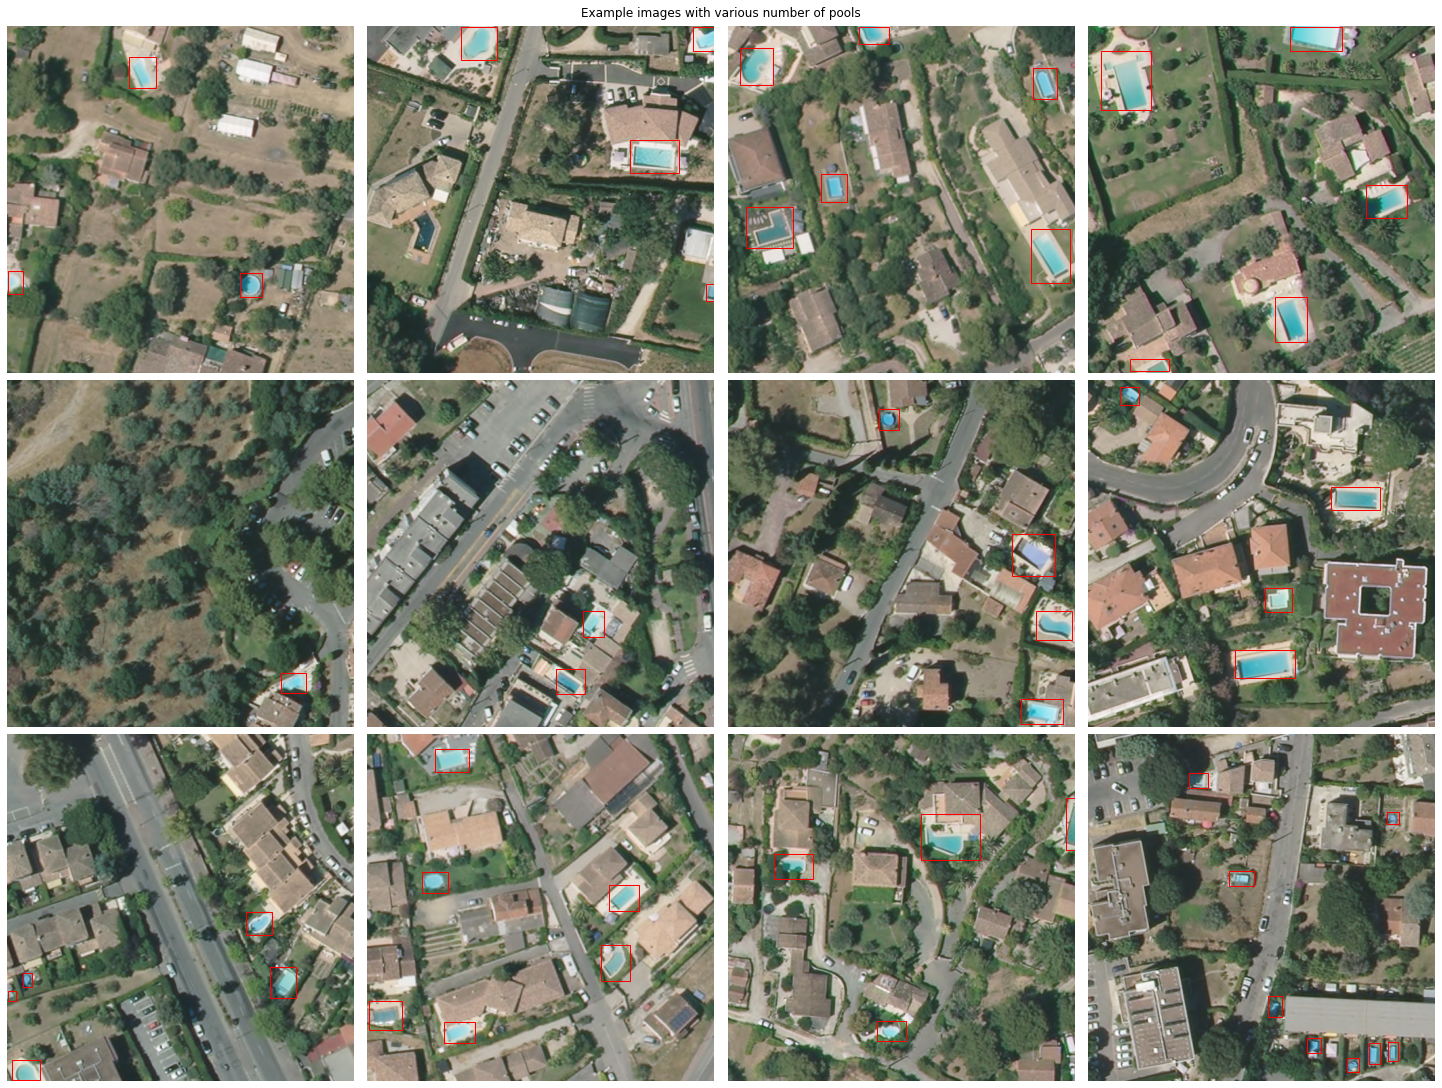

In [7]:
plot_image_examples(df, title='Example images with various number of pools')

<AxesSubplot:xlabel='nboxes', ylabel='Count'>

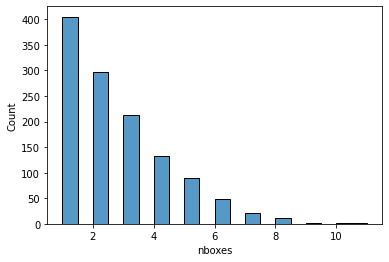

In [8]:
# compute the number of bounding boxes per train image
df['nboxes'] = df.apply(lambda row: 1 if np.isfinite(row.xmin) else 0, axis=1)
train_images_count = df.groupby('image_id').sum().reset_index()
sns.histplot(data=train_images_count['nboxes'], bins=20)

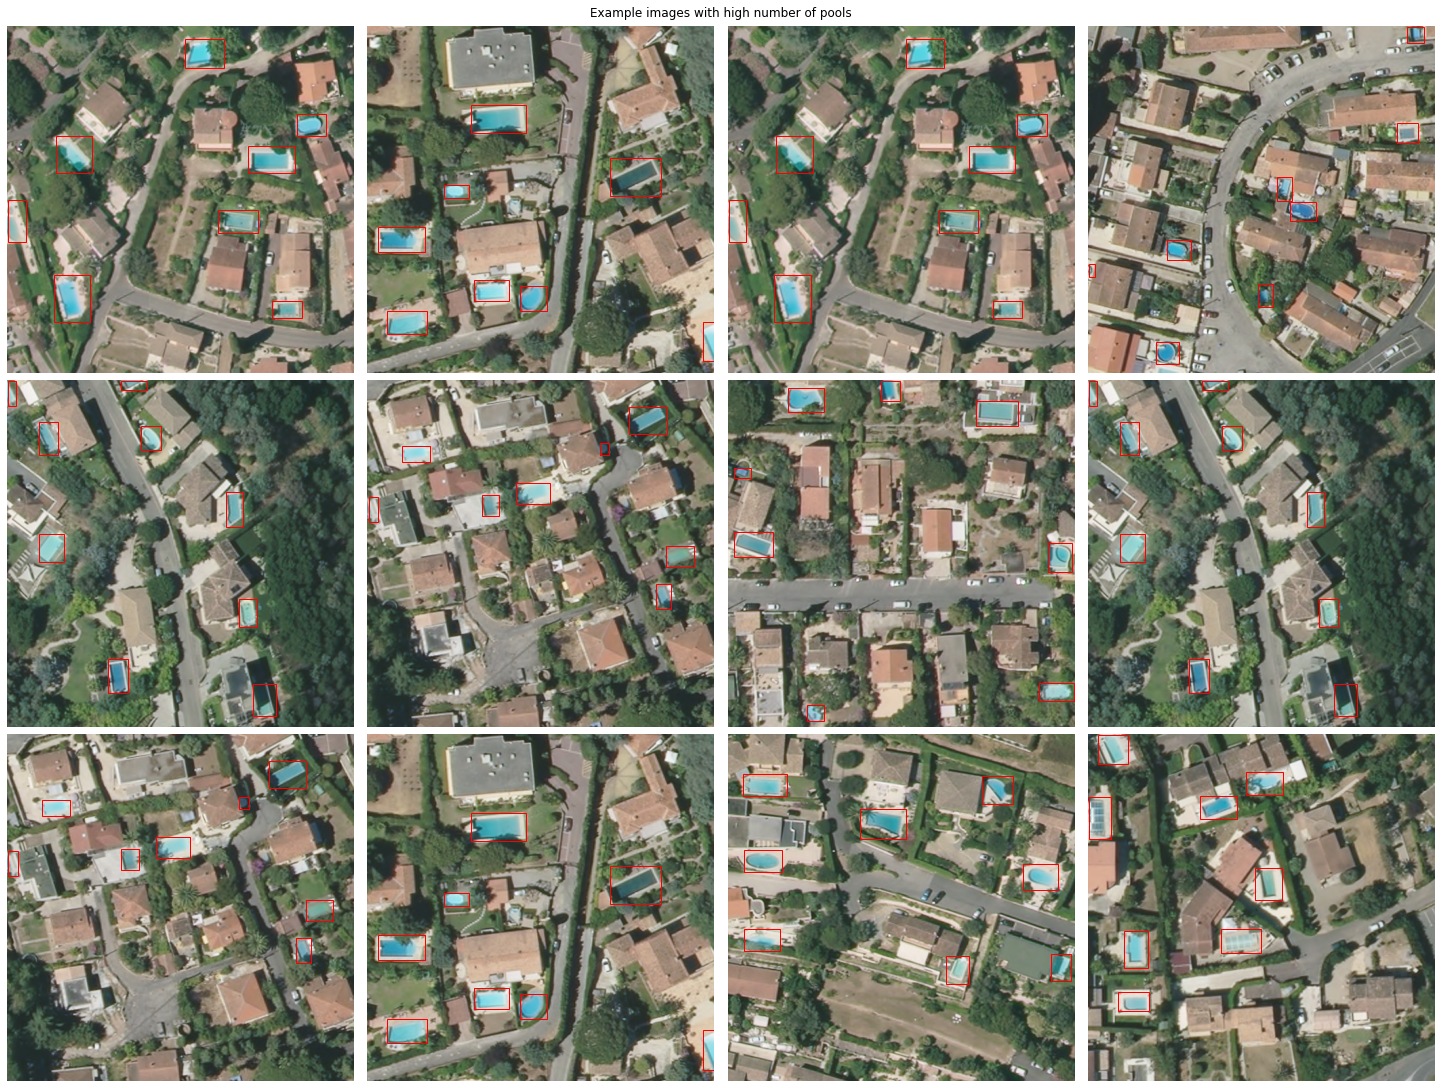

In [9]:
high_pool_ids = train_images_count[train_images_count['nboxes'] > 7].image_id
plot_image_examples(df[df.image_id.isin(high_pool_ids)], title='Example images with high number of pools')

### Compute areas

<AxesSubplot:xlabel='bbox_area', ylabel='Count'>

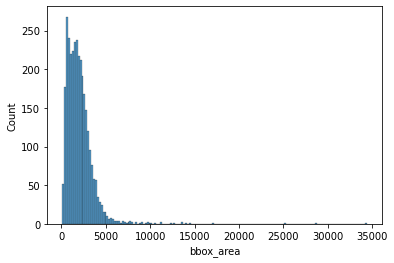

In [10]:
df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
sns.histplot(data=df['bbox_area'])

In [11]:
df.head()

image_id  width  height class  xmin  ymin  xmax  ymax  \
0  CANNES_TILES_512x512.1898.png    512     512  pool   151   219   183   257   
1   CANNES_TILES_512x512.476.png    512     512  pool   100   155   164   199   
2   CANNES_TILES_512x512.476.png    512     512  pool   456   162   502   207   
3   CANNES_TILES_512x512.670.png    512     512  pool   258   189   308   221   
4   CANNES_TILES_512x512.670.png    512     512  pool   344   134   396   162   

   fold  nboxes  bbox_area  
0     4       1       1216  
1     4       1       2816  
2     4       1       2070  
3     0       1       1600  
4     0       1       1456

In [12]:
df.to_csv('swimming_pools_labels_512x512.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.
